Running grid: 100%|██████████| 101/101 [07:37<00:00,  4.53s/it]


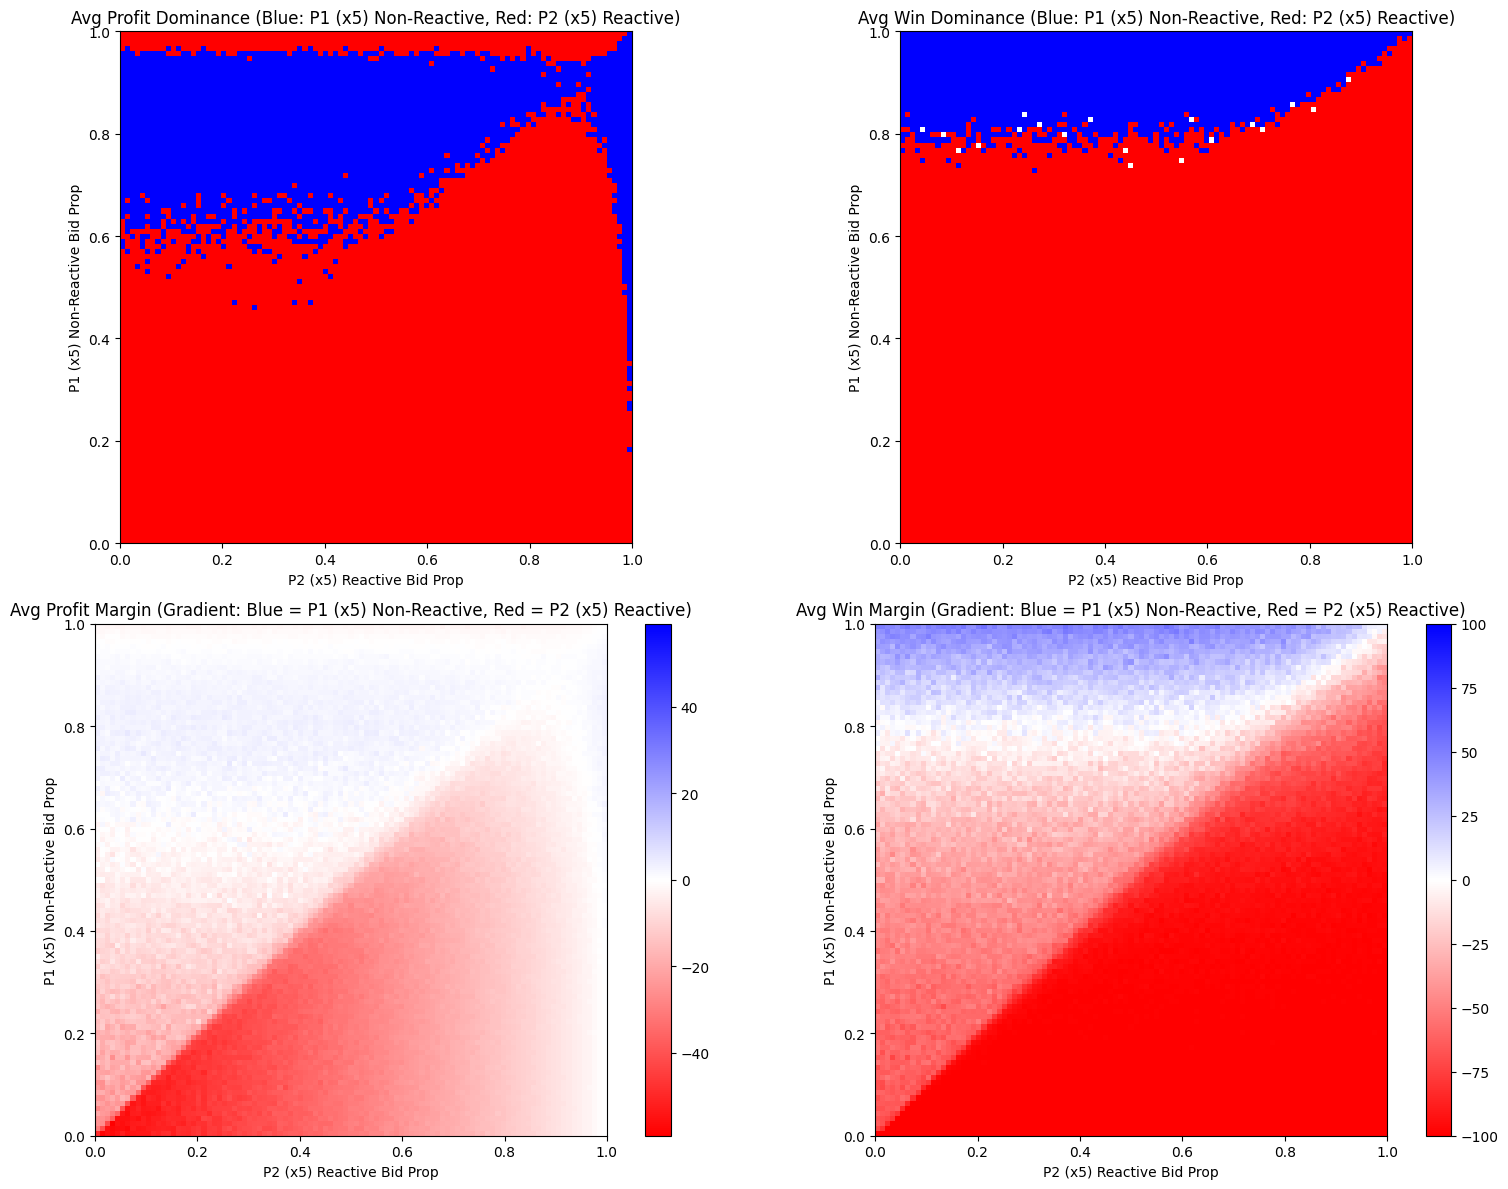

In [ ]:
# Bid Prop Analysis (Flexible: Asymmetric Teams, Normalized Results)

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.colors import ListedColormap, BoundaryNorm

from auction import Auction
from player import RangePlayer

# Simulation settings
bid_props = np.round(np.arange(0, 1.01, 0.01), 2)
n_rounds = 10000
speed_range = (0.0, 0.5)
reactive_speed_range = (0.0, 0.5)
cutoff_time_range = (1.0, 1.0)
sealed_bids = True

# Asymmetric team configuration
team1_size = 5
team2_size = 5
team1_reactive = False
team2_reactive = True

# Result matrices
profit_matrix = np.zeros((len(bid_props), len(bid_props)))
win_matrix = np.zeros((len(bid_props), len(bid_props)))
profit_margin = np.zeros((len(bid_props), len(bid_props)))
win_margin = np.zeros((len(bid_props), len(bid_props)))

# Grid search
for i, p1_bid_prop in enumerate(tqdm(bid_props, desc="Running grid")):
    for j, p2_bid_prop in enumerate(bid_props):
        team1 = [RangePlayer(1 + k, speed_range, [p1_bid_prop, 0.0], team1_reactive)
                 for k in range(team1_size)]
        team2 = [RangePlayer(100 + k, reactive_speed_range, [p2_bid_prop, 0.0], team2_reactive)
                 for k in range(team2_size)]
        players = team1 + team2

        auction = Auction(players, cutoff_time_range, sealed_bids)
        results, winnings = auction.run_simulation(n_rounds)

        # Normalize profits by team size
        p1_profit = sum(winnings[k] for k in range(team1_size)) / team1_size
        p2_profit = sum(winnings[team1_size + k] for k in range(team2_size)) / team2_size
        profit_margin[i, j] = p1_profit - p2_profit

        if p1_profit > p2_profit:
            profit_matrix[i, j] = 1
        elif p2_profit > p1_profit:
            profit_matrix[i, j] = 2

        # Count wins and normalize
        p1_wins = 0
        p2_wins = 0
        for round_data in results:
            winner = round_data['winner']
            if winner:
                pid = winner[0]
                if pid < 100:
                    p1_wins += 1
                else:
                    p2_wins += 1
        p1_win_avg = p1_wins / team1_size
        p2_win_avg = p2_wins / team2_size
        win_margin[i, j] = p1_win_avg - p2_win_avg

        if p1_win_avg > p2_win_avg:
            win_matrix[i, j] = 1
        elif p2_win_avg > p1_win_avg:
            win_matrix[i, j] = 2

# Label generator
def role_label(name, team_size, reactive):
    base = name if team_size == 1 else f"{name} (x{team_size})"
    return base + (" Reactive" if reactive else " Non-Reactive")

p1_label = role_label("P1", team1_size, team1_reactive)
p2_label = role_label("P2", team2_size, team2_reactive)

# Plotting
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

flat_cmap = ListedColormap(['white', 'blue', 'red'])
bounds = [0, 0.5, 1.5, 2.5]
norm = BoundaryNorm(bounds, flat_cmap.N)

# Discrete profit dominance
ax[0, 0].imshow(profit_matrix, origin='lower', extent=[0, 1, 0, 1], cmap=flat_cmap, norm=norm)
ax[0, 0].set_title(f"Avg Profit Dominance (Blue: {p1_label}, Red: {p2_label})")
ax[0, 0].set_xlabel(f"{p2_label} Bid Prop")
ax[0, 0].set_ylabel(f"{p1_label} Bid Prop")

# Discrete win dominance
ax[0, 1].imshow(win_matrix, origin='lower', extent=[0, 1, 0, 1], cmap=flat_cmap, norm=norm)
ax[0, 1].set_title(f"Avg Win Dominance (Blue: {p1_label}, Red: {p2_label})")
ax[0, 1].set_xlabel(f"{p2_label} Bid Prop")
ax[0, 1].set_ylabel(f"{p1_label} Bid Prop")

# Continuous profit margin
grad1 = ax[1, 0].imshow(profit_margin, origin='lower', extent=[0, 1, 0, 1],
                        cmap='bwr_r', vmin=-np.max(np.abs(profit_margin)), vmax=np.max(np.abs(profit_margin)))
ax[1, 0].set_title(f"Avg Profit Margin (Gradient: Blue = {p1_label}, Red = {p2_label})")
ax[1, 0].set_xlabel(f"{p2_label} Bid Prop")
ax[1, 0].set_ylabel(f"{p1_label} Bid Prop")
fig.colorbar(grad1, ax=ax[1, 0])

# Continuous win margin
grad2 = ax[1, 1].imshow(win_margin, origin='lower', extent=[0, 1, 0, 1],
                        cmap='bwr_r', vmin=-np.max(np.abs(win_margin)), vmax=np.max(np.abs(win_margin)))
ax[1, 1].set_title(f"Avg Win Margin (Gradient: Blue = {p1_label}, Red = {p2_label})")
ax[1, 1].set_xlabel(f"{p2_label} Bid Prop")
ax[1, 1].set_ylabel(f"{p1_label} Bid Prop")
fig.colorbar(grad2, ax=ax[1, 1])

plt.tight_layout()
plt.show()